<a href="https://colab.research.google.com/github/Coyote-Schmoyote/currency-exchange-prediction/blob/main/currency_exchange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Currency exchange rate prediction model

This notebook looks into Python-based machine learning and data science libraries in an attempt to analyze time series data and build a machine learning model that can predict the exchange rate of JPY to USD, and USD to EUR for a given day.

## 1. Problem Definition

#### Problem 1 
Fill in the missing NaN values with the data from the most recent previous day. 


#### Problem 2 
With the above data, visualize each statistic and the time series.

#### Problem 3

Display a histogram of the rate exchange, taking the difference between each day and the previous day (day - previous day).

#### Problem 4
Build a linear regression model to predict future prices (e.g., next day), using November 2016 as training data.
Use the price of the day as the target variable, and build a model that predicts the price of the day based on the prices from the previous days. Use December 2016 as test data.

## 2. Data

For this project, we are going to generate data using `pandas` module `pandas_datareader.data` to extract data from Federal Reserve Economic Data (FRED). We will take the exchange rate data for Japanese Yen to US Dollars, and US Dollars to Euro, starting January 2nd 2001, and ending December 30th 2016.
> More datasets supported by `pandas_datareader`: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html


In [ ]:
# Import the tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# Import linear regression model
from sklearn.linear_model import LinearRegression

# Import model evaluation tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error

# Generate data
import pandas_datareader.data as pdr
start_date = dt.datetime(2001,1,2)
end_date = dt.datetime(2016,12,30)

df = pdr.DataReader(["DEXJPUS", "DEXUSEU"], data_source="fred", start=start_date, end=end_date)


## Problem 1: Deal with missing data
>Fill in the missing NaN values with the data from the most recent previous day.


In our previous projects, we didn‘t have any missing data. However, in real world, the majority of datasets will have missing values. Even a small amount of missing data can cause major problems with analysis and machine learning process, and therefore, one of the first things we have to do when starting a new data science project is to make sure we have no missing values. The most common ways to handle missing data are:
* Imputation 
>Imputation method develops reasonable guesses for the missing data. It‘s useful when there is not a lot of missing data. If the proportion of missing data is too high, imputing data might affect the results of the machine learning model.
* Removal
>We can remove missing data. However, if the dataset is small it is not advisable to remove the missing values, because there might be not data to make reliable observations and produce trusted results.



First, let‘s take a look at our data.

In [ ]:
df

,DEXJPUS,DEXUSEU
DATE,,
2001-01-02,114.73,0.9465
2001-01-03,114.26,0.9473
2001-01-04,115.47,0.9448
2001-01-05,116.19,0.9535
2001-01-08,115.97,0.9486
...,...,...
2016-12-26,NaN,NaN
2016-12-27,117.52,1.0458
2016-12-28,117.66,1.0389


### Observations: 
In the dataframe, we can see date, exchange rate from JPY to USD, and an exchange rate from USD to EUR.
However, underneath the dataframe it shows us that the dataframe has only 2, and not 3, columns. In this project, we are working with a **Time Series** data, also refered to as time-staped data. Basically, time series data is a type of data, in which each data point is collected at different time. In our case, we have one new data point (exchange rate) every day. The date, then, is represented as an index in `pandas` DataFrame, and not a separate column. That is the reason there are only 2 columns, even though visually it seems like there are 3.

In [ ]:
# check the columns
df.columns

Index(['DEXJPUS', 'DEXUSEU'], dtype='object')

In [ ]:
#check the index
df.index

DatetimeIndex(['2001-01-02', '2001-01-03', '2001-01-04', '2001-01-05',
               '2001-01-08', '2001-01-09', '2001-01-10', '2001-01-11',
               '2001-01-12', '2001-01-15',
               ...
               '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22',
               '2016-12-23', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='DATE', length=4174, freq=None)

In [ ]:
# check datatypes of the columns
df.dtypes

DEXJPUS    float64
DEXUSEU    float64
dtype: object

### Time Series Data
<img src="https://www.influxdata.com/wp-content/uploads/regular-vs-irregular-time-series-data.png" align="right" width="500">
Time series data is any data that is collected at different points in time, and organized chronologically. This means that *time* is the main attribute that distinguishes this type of data from any other one. The time interval between each data point is called *time series frequency*. In our case, the frequency is 1 day. Some examples of analysis that relies on time series:
* Electrical activity in the brain
* Stock prices
* Exchange rate
* Annual retail sales
* Monthly subscribers
* Heartbeats per minute

Time series data is usually classified into two types:

1. Data gathered at regular time intervals (metrics)
> Examples of metrics data: heart rate monitoring (ECG) and brain monitoring (EEG), weather conditions, stock price changes.
2. Data gathered at irregular time intervals (events)
> Examples of events data: bank account withdrawals, computer logging, online purchase history.

We can use regular data (metrics) for forecasting and predicting what will happen in the future. However, events are unpredictable and cannot be modeled to predict what will happen in the future, because they are irregular. Apart from forecasting, we can use time series to conduct descriptive and explanatory analysis, as well as regression and classification analysis. We can also observe patterns, and see if there are any trends, seasonality, or cyclic behavior reflected in the data.


In [ ]:
# check number of missing values
df.isna().sum()

DEXJPUS    154
DEXUSEU    154
dtype: int64

In [ ]:
#fill missing values with the data from previous day
df.fillna(method="ffill", inplace=True) # "ffill": impute last valid observation forward to next

In [ ]:
df

,DEXJPUS,DEXUSEU
DATE,,
2001-01-02,114.73,0.9465
2001-01-03,114.26,0.9473
2001-01-04,115.47,0.9448
2001-01-05,116.19,0.9535
2001-01-08,115.97,0.9486
...,...,...
2016-12-26,117.22,1.0449
2016-12-27,117.52,1.0458
2016-12-28,117.66,1.0389


In [ ]:
df.isna().sum()

DEXJPUS    0
DEXUSEU    0
dtype: int64

### Problem 2: Visualize each statistic
The two most common ways to visualize data over time are line and bar plots. For time series, lines are the most efficient way to visualize the data, because it makes it more easy to see the trends, and emphasizes the continuous feeling.

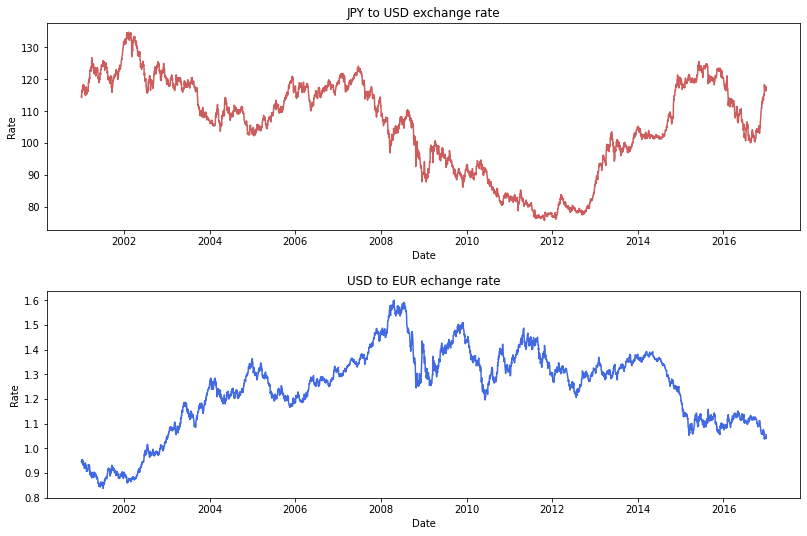

In [ ]:
# create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
fig.tight_layout(pad=4)

# plot JPYxUSD exchange rate
ax1.plot(df["DEXJPUS"], color="indianred")
ax1.set(title="JPY to USD exchange rate",
        xlabel="Date",
        ylabel="Rate")

# plot USDx EUR exchange rate
ax2.plot(df["DEXUSEU"], color="royalblue")
ax2.set(title="USD to EUR echange rate",
        xlabel="Date",
        ylabel="Rate");

We can also create bar plots. Bars are particularly helpful when we want to compare ratios with the nearby bars. Bar plot is not the best choice for our current project, but let‘s plot it for comparison.

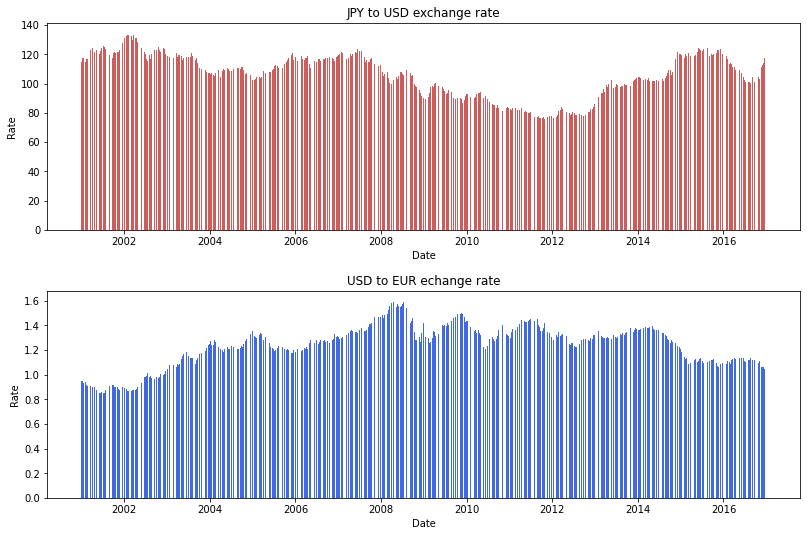

In [ ]:
# create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 8))
fig.tight_layout(pad=4)

# plot JPY x USD exchange rate
ax1.bar(df.index, df["DEXJPUS"], color="indianred")
ax1.set(title="JPY to USD exchange rate",
        xlabel="Date",
        ylabel="Rate")

# plot USD x EUR exchange rate
ax2.bar(df.index, df["DEXUSEU"], color="royalblue")
ax2.set(title="USD to EUR echange rate",
        xlabel="Date",
        ylabel="Rate");

### Problem 3: Plot a histogram
Display a histogram of the rate exchange, taking the difference between each day and the previous day (day - previous day).


To account for the previous date, we can use `pandas` method for time series, `dataFrame.shift()`. The `shift()`  method shifts index (date) by desired amount of periods. Let‘s take a look how it works. 

Here is our original datafame:

In [ ]:
df


,DEXJPUS,DEXUSEU
DATE,,
2001-01-02,114.73,0.9465
2001-01-03,114.26,0.9473
2001-01-04,115.47,0.9448
2001-01-05,116.19,0.9535
2001-01-08,115.97,0.9486
...,...,...
2016-12-26,117.22,1.0449
2016-12-27,117.52,1.0458
2016-12-28,117.66,1.0389


Now, let‘s try using `shift()` method. `Shift(1)` shifts 1 day forward:

In [ ]:
df.shift(1)

,DEXJPUS,DEXUSEU
DATE,,
2001-01-02,NaN,NaN
2001-01-03,114.73,0.9465
2001-01-04,114.26,0.9473
2001-01-05,115.47,0.9448
2001-01-08,116.19,0.9535
...,...,...
2016-12-26,117.22,1.0449
2016-12-27,117.22,1.0449
2016-12-28,117.52,1.0458


`Shift(-3)`, on the other hand, shifts 3 days backwards.

In [ ]:
df.shift(-3)

,DEXJPUS,DEXUSEU
DATE,,
2001-01-02,116.19,0.9535
2001-01-03,115.97,0.9486
2001-01-04,116.64,0.9397
2001-01-05,116.26,0.9387
2001-01-08,117.56,0.9520
...,...,...
2016-12-26,116.32,1.0486
2016-12-27,116.78,1.0552
2016-12-28,NaN,NaN


Now let`s plot a histogram.

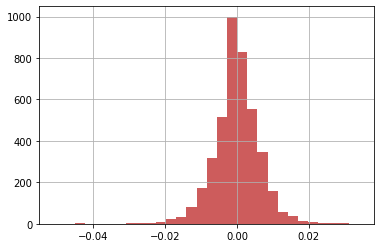

In [ ]:
# JPYxUSD histogram
JPY_USD = (df["DEXJPUS"] - df["DEXJPUS"].shift(1)) / df["DEXJPUS"].shift(1)
JPY_USD.hist(bins=30, color="indianred");

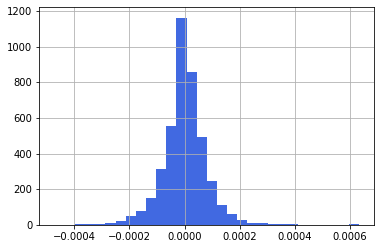

In [ ]:
# Plot a USD x EUR histogram
USD_EUR = (df["DEXUSEU"] - df["DEXUSEU"].shift(1)) / df["DEXJPUS"].shift(1)
USD_EUR.hist(bins=30, color="royalblue");

### Problem 4: Build a model 
Build a linear regression model to predict future prices (e.g., next day), using DEXJPUS November 2016 as training data. Use the price of the day as the target variable, and build a model that predicts the price of the day based on the prices from the previous days. Use December 2016 as test data.

In [ ]:
# Drop DEXUSEU column
JPY_USD_df = df.drop("DEXUSEU", axis=1)

In [ ]:
JPY_USD_df

,DEXJPUS
DATE,
2001-01-02,114.73
2001-01-03,114.26
2001-01-04,115.47
2001-01-05,116.19
2001-01-08,115.97
...,...
2016-12-26,117.22
2016-12-27,117.52
2016-12-28,117.66


In [ ]:
# create a dataframe that has information with up to 3 days beofre "today"
three_days_df = pd.concat([
                JPY_USD_df,
                JPY_USD_df.shift(1),
                JPY_USD_df.shift(2),
                JPY_USD_df.shift(3)
], axis=1)

three_days_df

,DEXJPUS,DEXJPUS,DEXJPUS,DEXJPUS
DATE,,,,
2001-01-02,114.73,NaN,NaN,NaN
2001-01-03,114.26,114.73,NaN,NaN
2001-01-04,115.47,114.26,114.73,NaN
2001-01-05,116.19,115.47,114.26,114.73
2001-01-08,115.97,116.19,115.47,114.26
...,...,...,...,...
2016-12-26,117.22,117.22,117.48,117.79
2016-12-27,117.52,117.22,117.22,117.48
2016-12-28,117.66,117.52,117.22,117.22


In [ ]:
# name the columns and drop rows with NaN values
three_days_df.columns = ["today", "yesterday", "2 days ago", "3 days ago"]
three_days_df.dropna(inplace=True)

In [ ]:
three_days_df

,today,yesterday,2 days ago,3 days ago
DATE,,,,
2001-01-05,116.19,115.47,114.26,114.73
2001-01-08,115.97,116.19,115.47,114.26
2001-01-09,116.64,115.97,116.19,115.47
2001-01-10,116.26,116.64,115.97,116.19
2001-01-11,117.56,116.26,116.64,115.97
...,...,...,...,...
2016-12-26,117.22,117.22,117.48,117.79
2016-12-27,117.52,117.22,117.22,117.48
2016-12-28,117.66,117.52,117.22,117.22


Now we are ready to split data to train and test data. Before, we used `scikit-learn` module `train_test_split`. However, this time we don‘t need to split the data at random, because we are using November as train, and December as test data. Therefore, we will do it manually.

In [ ]:
# separate 2016 november and december

nov = three_days_df["2016-11-01":"2016-11-30"]
dec = three_days_df["2016-12-01":"2016-12-31"]

nov

,today,yesterday,2 days ago,3 days ago
DATE,,,,
2016-11-01,104.59,105.07,105.40,105.14
2016-11-02,103.22,104.59,105.07,105.40
2016-11-03,103.17,103.22,104.59,105.07
2016-11-04,103.02,103.17,103.22,104.59
2016-11-07,104.60,103.02,103.17,103.22
2016-11-08,104.98,104.60,103.02,103.17
2016-11-09,104.84,104.98,104.60,103.02
2016-11-10,106.56,104.84,104.98,104.60
2016-11-11,106.56,106.56,104.84,104.98


In [ ]:
dec

,today,yesterday,2 days ago,3 days ago
DATE,,,,
2016-12-01,114.34,114.34,112.78,112.36
2016-12-02,113.76,114.34,114.34,112.78
2016-12-05,114.10,113.76,114.34,114.34
2016-12-06,113.98,114.10,113.76,114.34
2016-12-07,113.50,113.98,114.10,113.76
2016-12-08,114.16,113.50,113.98,114.10
2016-12-09,115.17,114.16,113.50,113.98
2016-12-12,115.34,115.17,114.16,113.50
2016-12-13,115.26,115.34,115.17,114.16


In [ ]:
# split data into train test
X_train = nov.drop("today", axis=1)
y_train = nov["today"]
X_test = dec.drop("today", axis=1)
y_test = dec["today"]

# instantiate model
model = LinearRegression()

# fit the model
fit_model = model.fit(X_train, y_train)

In [ ]:
# Model score
fit_model.score(X_test, y_test)

0.5404389520765203

### Observations: 
Our model got 0.54 score. In other words, it could predict approximately half of the labels. We used very limited amount of training data, which explains the low score.

If we took 80% of our data, and used the rest of 20% as test data, as we normally do, we would receive much better results.

In [ ]:
# import train_test_split

from sklearn.model_selection import train_test_split

# split all data into X and y
X = three_days_df.drop("today", axis=1)
y = three_days_df["today"]

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)


In [ ]:
# instantiate model
model = LinearRegression()

# fit model
fitted_model = model.fit(X_train, y_train)

# score model
fitted_model.score(X_test, y_test)

0.9980206655365427

In comparison with our previous model, after using all available data from our 2001-2016 dataset, we received a nearly perfect score.